# Importing the libraries

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from random import randint

import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from xgboost import XGBRegressor, plot_importance


c:\Users\Pedro\OneDrive - Instituto Maua de Tecnologia\5e_encounter_predictor\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Defining functions

In [4]:
COLORS = ['#8c1b3f','#fe0151', '#0c7ff4', '#3eb1ff']
CMAP = LinearSegmentedColormap.from_list('my_cmap', COLORS)

def print_regression_report(x_test, y_test, model, title):
    y_hat = model.predict(x_test)
    
    print(f'{"="*53}\n{title}\n{"="*53}')
    print('Mean Squared Error:\t\t', mean_squared_error(y_test, y_hat))
    print('Mean Absolute Error:\t\t', mean_absolute_error(y_test, y_hat))
    print('R²:\t\t\t\t', r2_score(y_test, y_hat))
    print('Root Mean Squared Error:\t', np.sqrt(mean_squared_error(y_test, y_hat)))
    
    
def plot_residual_distribution(x_test, y_test, model, main_color, title, secondary_color):
    residuals = y_test - model.predict(x_test)
    
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(residuals, color=main_color, kde=True, label='Residuals', line_kws={'linewidth': 2, 'label': 'Density'})
    ax.set_title(f'Residuals distribution - {title}')
    ax.set_xlabel('Residual value')
    ax.set_ylabel('')
    ax.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], colors=secondary_color, linestyles=':', label='Zero', linewidth=3)
    ax.legend();
    
def plot_residual_comparison(x_test, y_test, model, main_color, title, secondary_color):
    residuals = y_test - model.predict(x_test)
    
    plt.figure(figsize=(10, 6))
    ax = sns.scatterplot(x=y_test, y=residuals, color=main_color, label='Residuals')
    ax.set_title(f'Residuals comparison - {title}')
    ax.set_xlabel('True value')
    ax.set_ylabel('Residual value')
    ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], colors=secondary_color, linestyles=':', label='Zero', linewidth=3)
    ax.legend();
    
def plot_feature_importance(model, x_test):
    explaner = shap.TreeExplainer(model)
    shap_values = explaner.shap_values(x_test)
    shap.summary_plot(shap_values, x_test, plot_type="violin", max_display=10)
    
def predict(model,test, Y, normalizer=MinMaxScaler(), scaler=StandardScaler()):
    input_test = randint(0, len(test))
    row_input = pd.DataFrame(test.iloc[input_test]).T
    try:
        print_input = pd.DataFrame(normalizer.inverse_transform(row_input), columns=row_input.columns)
    except:
        try:
            print_input = pd.DataFrame(scaler.inverse_transform(row_input), columns=row_input.columns) # type: ignore
        except:
            print_input = row_input 
    print('Input: ')
    print(f'The combat was between 4 players level {int(print_input.players_level.values[0])} against {int(print_input.num_of_monsters.values[0])} monster(s) CR {print_input.monster_cr.values[0]}')
    print('Expected: ', Y.iloc[input_test])
    print('Predicted: ', model.predict(row_input)[0])

# Importing the dataset

In [5]:
df = pd.read_csv('../Data/results_v6.csv')
df.sample(5)

,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_ac,p4_avg_save,num_of_monsters,monster_name,monster_cr,monster_ac,monster_hp,monster_type,dificulty,players_level
32170,Druid,12,11,2,Fighter,20,15,2,Bard,12,...,11,2,10,Nupperibo,0.50,13,11,fiend,0.000000,2
59801,Cleric,27,19,3,Cleric,26,13,3,Fighter,41,...,19,3,10,Elk,0.25,10,13,beast,0.373292,4
10955,Paladin,44,17,3,Druid,46,16,3,Ranger,42,...,17,3,4,Brontosaurus,5.00,15,121,beast,0.000000,5
48721,Bard,19,15,2,Monk,11,12,2,Rogue,10,...,15,2,1,Griffon,2.00,12,59,monstrosity,0.804193,2
31322,Druid,30,16,3,Paladin,28,17,3,Bard,22,...,15,3,1,Red Slaad,5.00,14,93,aberration,0.914368,3


In [6]:
df_test = pd.read_csv('../Data/test_sample.csv', encoding='utf-8')
df_test.sample(5)

,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_ac,p4_avg_save,num_of_monsters,monster_name,monster_cr,monster_ac,monster_hp,monster_type,dificulty,players_level
124,Fighter,56,17,3,Fighter,42,17,3,Wizzard,28,...,11,3,3,Green Dragon Wyrmling,2.0,17,38,dragon,0.849228,5
2307,Warlock,36,14,3,Ranger,49,17,3,Druid,25,...,13,3,2,Lamia,4.0,13,97,monstrosity,0.702815,4
1063,Bard,33,15,3,Wizzard,24,13,3,Fighter,40,...,15,3,1,Ghost,4.0,11,45,undead,0.913295,4
1320,Sorcerer,23,10,3,Barbarian,38,15,3,Druid,30,...,12,3,1,Manticore,3.0,14,68,monstrosity,0.958037,3
3249,Warlock,39,13,3,Paladin,57,18,3,Rogue,23,...,11,3,1,Flind,9.0,16,127,fiend,0.899062,5


In [7]:
all_monsters = pd.read_csv('../Data/5e_monster_data_5eTools.csv')
all_monsters.sample(5)

,Unnamed: 0,name,hp,hp formula,hp special,ac,ac special,cr,str,dex,...,walk,fly,swim,burrow,climb,hover,size,alignment,type,source
2282,2282,Giant Slug,66,6d10 + 18,-,13,-,3,14,13,...,10,-,-,-,10,-,L,U,monstrosity,TTP
1964,1964,Griffin (Type 2),19,3d10 + 3,-,11,-,1,17,13,...,40,60,-,-,-,-,L,U,monstrosity,PSZ
557,557,Zegana,130,20d8 + 40,-,16,-,16,11,14,...,30,-,40,-,-,-,M,LN,humanoid,GGR
2536,2536,Choldrith,66,12d8 + 12,-,15,-,3,12,16,...,30,-,-,-,30,-,M,CE,monstrosity,VGM
1111,1111,Killer Whale,90,12d12 + 12,-,12,-,3,19,10,...,-,-,60,-,-,-,H,U,beast,MM


# Cleaning the data

## Dropping the columns that wont help in prediction

In [8]:
df_test_result = df_test[['dificulty']]
df_test_result.head()

,dificulty
0,0.880663
1,0.929774
2,0.534813
3,0.642994
4,0.000000


In [9]:
df_test.drop(columns=['dificulty'], inplace=True)
df_test.head()

,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_hp,p4_ac,p4_avg_save,num_of_monsters,monster_name,monster_cr,monster_ac,monster_hp,monster_type,players_level
0,Fighter,10,18,2,Artificer,9,17,2,Cleric,6,...,8,18,2,1,Swarm of Quippers,1.00,13,28,beast,1
1,Paladin,40,18,3,Rogue,25,16,3,Fighter,37,...,57,17,3,1,Kraken Priest,5.00,15,75,monstrosity,5
2,Warlock,15,13,2,Ranger,17,16,2,Fighter,17,...,12,14,2,2,Quetzalcoatlus,2.00,13,30,beast,2
3,Monk,16,13,3,Monk,18,11,3,Paladin,26,...,30,12,3,1,Triceratops,5.00,13,95,beast,3
4,Wizzard,4,11,2,Paladin,11,15,2,Sorcerer,6,...,6,16,2,10,Duodrone,0.25,15,11,construct,1


## Dropping miswrote data


In [10]:
df = df[df['p1_class'] != '22']
df = df[df['dificulty'] >= 0]
df = df[df['monster_cr'] != -1]
df = df[df['players_level'] <= 5]
df.head()

,p1_class,p1_hp,p1_ac,p1_avg_save,p2_class,p2_hp,p2_ac,p2_avg_save,p3_class,p3_hp,...,p4_ac,p4_avg_save,num_of_monsters,monster_name,monster_cr,monster_ac,monster_hp,monster_type,dificulty,players_level
0,Artificer,38,12,3,Bard,38,13,3,Barbarian,51,...,14,3,1,Efreeti,11.00,17,200,elemental,0.869491,5
1,Bard,24,12,3,Barbarian,36,17,3,Sorcerer,13,...,15,3,10,Giant Bat,0.25,13,22,beast,0.067640,3
2,Ranger,17,12,2,Ranger,12,15,2,Druid,12,...,14,2,1,Galeb Duhr,6.00,16,85,elemental,1.000000,2
3,Fighter,32,18,3,Paladin,32,19,3,Paladin,21,...,13,3,1,Blue Slaad,7.00,15,123,aberration,0.285597,3
4,Cleric,26,12,3,Paladin,34,15,3,Cleric,25,...,13,3,4,Lizardfolk Shaman,2.00,13,27,humanoid,0.445773,4


## Adding the *size* column

In [11]:
all_monsters['monster_size'] = all_monsters['size']
all_monsters.drop(columns=['size'], inplace=True)

merged = df.merge(all_monsters[['name', 'monster_size']], left_on='monster_name', right_on='name', how='left')

merged.drop(columns=['name', 'monster_name'], inplace=True)

merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131030 entries, 0 to 131029
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p1_class         131030 non-null  object 
 1   p1_hp            131030 non-null  int64  
 2   p1_ac            131030 non-null  int64  
 3   p1_avg_save      131030 non-null  int64  
 4   p2_class         131030 non-null  object 
 5   p2_hp            131030 non-null  int64  
 6   p2_ac            131030 non-null  int64  
 7   p2_avg_save      131030 non-null  int64  
 8   p3_class         131030 non-null  object 
 9   p3_hp            131030 non-null  int64  
 10  p3_ac            131030 non-null  int64  
 11  p3_avg_save      131030 non-null  int64  
 12  p4_class         131030 non-null  object 
 13  p4_hp            131030 non-null  int64  
 14  p4_ac            131030 non-null  int64  
 15  p4_avg_save      131030 non-null  int64  
 16  num_of_monsters  131030 non-null  int6

In [12]:
merged_test = df_test.merge(all_monsters[['name', 'monster_size']], left_on='monster_name', right_on='name', how='left')

merged_test.drop(columns=['name', 'monster_name'], inplace=True)

merged_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5743 entries, 0 to 5742
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p1_class         5743 non-null   object 
 1   p1_hp            5743 non-null   int64  
 2   p1_ac            5743 non-null   int64  
 3   p1_avg_save      5743 non-null   int64  
 4   p2_class         5743 non-null   object 
 5   p2_hp            5743 non-null   int64  
 6   p2_ac            5743 non-null   int64  
 7   p2_avg_save      5743 non-null   int64  
 8   p3_class         5743 non-null   object 
 9   p3_hp            5743 non-null   int64  
 10  p3_ac            5743 non-null   int64  
 11  p3_avg_save      5743 non-null   int64  
 12  p4_class         5743 non-null   object 
 13  p4_hp            5743 non-null   int64  
 14  p4_ac            5743 non-null   int64  
 15  p4_avg_save      5743 non-null   int64  
 16  num_of_monsters  5743 non-null   int64  
 17  monster_cr    

#### Dropping NaN values

In [13]:
merged.dropna(inplace=True)
merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130856 entries, 0 to 131029
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p1_class         130856 non-null  object 
 1   p1_hp            130856 non-null  int64  
 2   p1_ac            130856 non-null  int64  
 3   p1_avg_save      130856 non-null  int64  
 4   p2_class         130856 non-null  object 
 5   p2_hp            130856 non-null  int64  
 6   p2_ac            130856 non-null  int64  
 7   p2_avg_save      130856 non-null  int64  
 8   p3_class         130856 non-null  object 
 9   p3_hp            130856 non-null  int64  
 10  p3_ac            130856 non-null  int64  
 11  p3_avg_save      130856 non-null  int64  
 12  p4_class         130856 non-null  object 
 13  p4_hp            130856 non-null  int64  
 14  p4_ac            130856 non-null  int64  
 15  p4_avg_save      130856 non-null  int64  
 16  num_of_monsters  130856 non-null  int64  
 

In [14]:
merged_test.dropna(inplace=True)
merged_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5732 entries, 0 to 5742
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p1_class         5732 non-null   object 
 1   p1_hp            5732 non-null   int64  
 2   p1_ac            5732 non-null   int64  
 3   p1_avg_save      5732 non-null   int64  
 4   p2_class         5732 non-null   object 
 5   p2_hp            5732 non-null   int64  
 6   p2_ac            5732 non-null   int64  
 7   p2_avg_save      5732 non-null   int64  
 8   p3_class         5732 non-null   object 
 9   p3_hp            5732 non-null   int64  
 10  p3_ac            5732 non-null   int64  
 11  p3_avg_save      5732 non-null   int64  
 12  p4_class         5732 non-null   object 
 13  p4_hp            5732 non-null   int64  
 14  p4_ac            5732 non-null   int64  
 15  p4_avg_save      5732 non-null   int64  
 16  num_of_monsters  5732 non-null   int64  
 17  monster_cr       57

# Exploring the data

## Seeing the correlation between the data

### Correlation in regrads to the target

In [15]:
corr_matrix = df.corr(numeric_only=True)
abs(corr_matrix['dificulty']).sort_values(ascending = False)

dificulty          1.000000
num_of_monsters    0.244230
players_level      0.176662
p3_hp              0.176218
p2_hp              0.174881
p1_hp              0.174119
p4_hp              0.172930
p2_avg_save        0.143449
p3_avg_save        0.143449
p4_avg_save        0.143449
p1_avg_save        0.143449
monster_hp         0.098328
monster_cr         0.055285
monster_ac         0.048969
p1_ac              0.039577
p4_ac              0.037814
p3_ac              0.037377
p2_ac              0.033942
Name: dificulty, dtype: float64

### Correlation in regrads to each other

In [16]:
corr_matrix

,p1_hp,p1_ac,p1_avg_save,p2_hp,p2_ac,p2_avg_save,p3_hp,p3_ac,p3_avg_save,p4_hp,p4_ac,p4_avg_save,num_of_monsters,monster_cr,monster_ac,monster_hp,dificulty,players_level
p1_hp,1.000000,0.097779,0.760145,0.771475,-0.000335,0.760145,0.771640,-0.002646,0.760145,0.771471,0.001654,0.760145,0.011625,0.307554,0.135904,0.277164,0.174119,0.877996
p1_ac,0.097779,1.000000,0.003035,0.003665,0.003515,0.003035,0.006203,0.002559,0.003035,0.005389,-0.002774,0.003035,-0.003024,0.003276,0.002211,0.001906,0.039577,0.005144
p1_avg_save,0.760145,0.003035,1.000000,0.760556,0.002004,1.000000,0.760603,0.002767,1.000000,0.760499,0.002318,1.000000,0.015902,0.274914,0.123667,0.248262,0.143449,0.865503
p2_hp,0.771475,0.003665,0.760556,1.000000,0.096176,0.760556,0.770257,-0.002652,0.760556,0.772318,0.002066,0.760556,0.010628,0.308320,0.135374,0.276738,0.174881,0.878134
p2_ac,-0.000335,0.003515,0.002004,0.096176,1.000000,0.002004,-0.001092,0.000018,0.002004,-0.000010,-0.003318,0.002004,0.004797,-0.004691,-0.007957,-0.002871,0.033942,-0.000855
p2_avg_save,0.760145,0.003035,1.000000,0.760556,0.002004,1.000000,0.760603,0.002767,1.000000,0.760499,0.002318,1.000000,0.015902,0.274914,0.123667,0.248262,0.143449,0.865503
p3_hp,0.771640,0.006203,0.760603,0.770257,-0.001092,0.760603,1.000000,0.091890,0.760603,0.771941,0.002221,0.760603,0.010298,0.308398,0.135855,0.276856,0.176218,0.877997
p3_ac,-0.002646,0.002559,0.002767,-0.002652,0.000018,0.002767,0.091890,1.000000,0.002767,-0.001706,-0.003256,0.002767,-0.004786,0.002592,0.000725,0.001429,0.037377,-0.002621
p3_avg_save,0.760145,0.003035,1.000000,0.760556,0.002004,1.000000,0.760603,0.002767,1.000000,0.760499,0.002318,1.000000,0.015902,0.274914,0.123667,0.248262,0.143449,0.865503
p4_hp,0.771471,0.005389,0.760499,0.772318,-0.000010,0.760499,0.771941,-0.001706,0.760499,1.000000,0.095816,0.760499,0.009680,0.311439,0.137778,0.280842,0.172930,0.878698


# Sampling the data

## Dividing the data into variables and target

In [17]:
X = merged.drop(columns=['dificulty'])
Y = merged['dificulty'].copy()

## One hot encoding the categorical data

In [18]:
encoder = OneHotEncoder(sparse_output=False).set_output(transform='pandas')

features_df = encoder.fit_transform(X[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type','monster_size']]) # type: ignore
X_encoded = pd.concat([X, features_df], axis=1).drop(columns=['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type','monster_size'])
X_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 130856 entries, 0 to 131029
Data columns (total 89 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   p1_hp                     130856 non-null  int64  
 1   p1_ac                     130856 non-null  int64  
 2   p1_avg_save               130856 non-null  int64  
 3   p2_hp                     130856 non-null  int64  
 4   p2_ac                     130856 non-null  int64  
 5   p2_avg_save               130856 non-null  int64  
 6   p3_hp                     130856 non-null  int64  
 7   p3_ac                     130856 non-null  int64  
 8   p3_avg_save               130856 non-null  int64  
 9   p4_hp                     130856 non-null  int64  
 10  p4_ac                     130856 non-null  int64  
 11  p4_avg_save               130856 non-null  int64  
 12  num_of_monsters           130856 non-null  int64  
 13  monster_cr                130856 non-null  float6

In [19]:
test_features_df = encoder.transform(merged_test[['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type','monster_size']]) # type: ignore
df_test_encoded = pd.concat([merged_test, test_features_df], axis=1).drop(columns=['p1_class', 'p2_class', 'p3_class', 'p4_class', 'monster_type','monster_size'])
df_test_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5732 entries, 0 to 5742
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   p1_hp                     5732 non-null   int64  
 1   p1_ac                     5732 non-null   int64  
 2   p1_avg_save               5732 non-null   int64  
 3   p2_hp                     5732 non-null   int64  
 4   p2_ac                     5732 non-null   int64  
 5   p2_avg_save               5732 non-null   int64  
 6   p3_hp                     5732 non-null   int64  
 7   p3_ac                     5732 non-null   int64  
 8   p3_avg_save               5732 non-null   int64  
 9   p4_hp                     5732 non-null   int64  
 10  p4_ac                     5732 non-null   int64  
 11  p4_avg_save               5732 non-null   int64  
 12  num_of_monsters           5732 non-null   int64  
 13  monster_cr                5732 non-null   float64
 14  monster_ac   

In [20]:
print(Y.shape)
print(X_encoded.shape)

(130856,)
(130856, 89)


## Splitting the dataset into the Training set and Test set

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y, test_size=.2)

# Building the model

## Making a rough model, without any hyperparameter tuning

### Training the model

In [22]:

regXGB = XGBRegressor(eval_metric='rmse',early_stopping_rounds=10,)
regXGB.fit( X_train,
            Y_train,
            verbose=20,
            eval_set=[(X_train, Y_train),(X_test, Y_test)]
            );

[0]	validation_0-rmse:0.34972	validation_1-rmse:0.35006
[20]	validation_0-rmse:0.22629	validation_1-rmse:0.23178
[40]	validation_0-rmse:0.20164	validation_1-rmse:0.20981
[60]	validation_0-rmse:0.18370	validation_1-rmse:0.19432
[80]	validation_0-rmse:0.17036	validation_1-rmse:0.18340
[99]	validation_0-rmse:0.16495	validation_1-rmse:0.18028


### Looking at the model results

In [23]:
title = 'Raw XGBoost'

#### Model scores on the test set

In [24]:
print_regression_report(X_test,Y_test,regXGB,title)

Raw XGBoost
Mean Squared Error:		 0.032502160275559897
Mean Absolute Error:		 0.1351275608420211
R²:				 0.7919742073886282
Root Mean Squared Error:	 0.18028355520002343


#### Model resisuals distribution

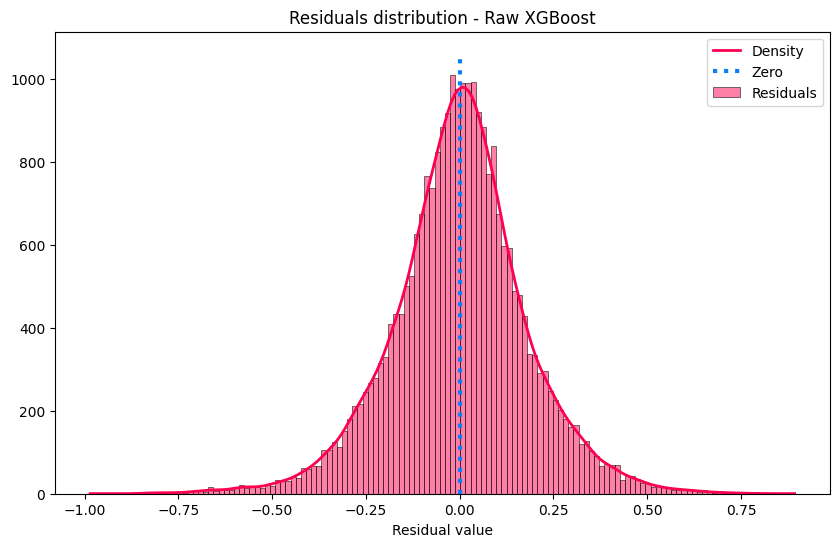

In [25]:
plot_residual_distribution(X_test, Y_test, regXGB, COLORS[1], title, COLORS[2])

#### Model resisuals vs true values

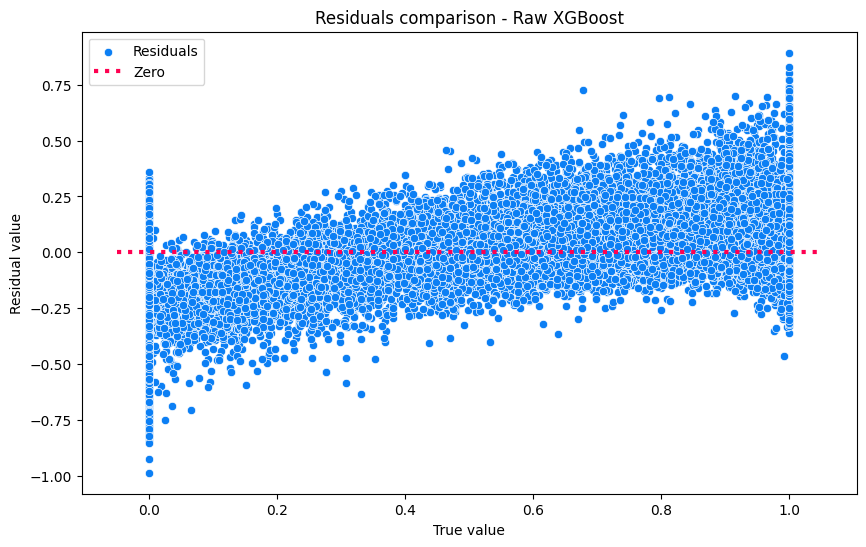

In [26]:
plot_residual_comparison(X_test, Y_test, regXGB, COLORS[2], title, COLORS[1])

#### Model features importance (SHAP values)

[02:20:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


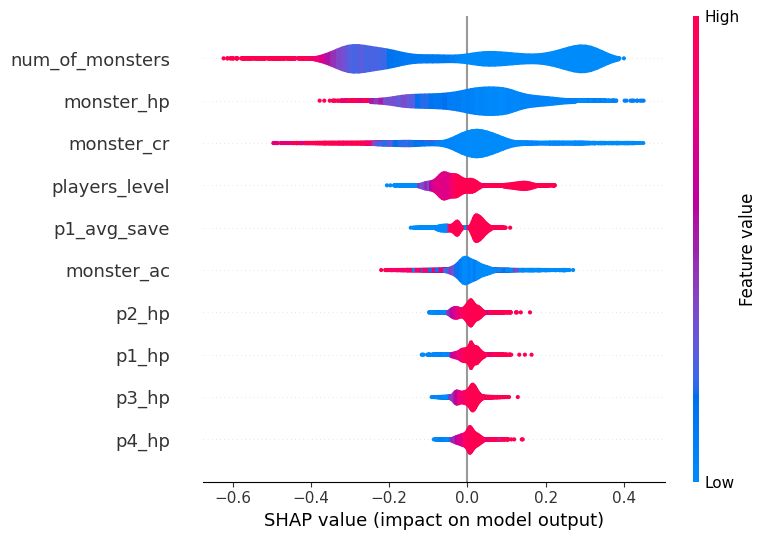

In [27]:
plot_feature_importance(regXGB, X_test);

### Predicting the using the model

In [28]:
predict(regXGB, X_test, Y_test)

Input: 
The combat was between 4 players level 4 against 10 monster(s) CR 1.0
Expected:  0.0
Predicted:  0.304003


## Hyperparameter tuning using ``Optuna``

### Defining the objective function

In [29]:
from tabnanny import verbose


def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 7)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.2, step=0.05)
    gamma = trial.suggest_float('gamma', 0.0, 0.3, step=0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 7)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 0.7, step=0.1)

    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        random_state=7, 
        n_jobs=-1,
        eval_metric='rmse',
        eval_set=[(X_train, Y_train),(X_test, Y_test)]
        )
    
    model.fit(
        X_train,
        Y_train,
        verbose=False
        )
    Y_pred = model.predict(X_test)
    return mean_squared_error(Y_test, Y_pred)

### Training the model's hyperparameters

In [32]:
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=200, n_jobs=-1) # type: ignore
study.best_params

[I 2023-12-15 02:22:11,105] A new study created in memory with name: regression
[I 2023-12-15 02:22:14,212] Trial 6 finished with value: 0.06890357711622185 and parameters: {'n_estimators': 64, 'max_depth': 3, 'learning_rate': 0.2, 'gamma': 0.2, 'min_child_weight': 7, 'colsample_bytree': 0.6000000000000001}. Best is trial 6 with value: 0.06890357711622185.
[I 2023-12-15 02:22:15,581] Trial 0 finished with value: 0.049142052269612546 and parameters: {'n_estimators': 54, 'max_depth': 7, 'learning_rate': 0.15000000000000002, 'gamma': 0.2, 'min_child_weight': 2, 'colsample_bytree': 0.3}. Best is trial 0 with value: 0.049142052269612546.
[I 2023-12-15 02:22:15,836] Trial 4 finished with value: 0.05457690385700556 and parameters: {'n_estimators': 68, 'max_depth': 5, 'learning_rate': 0.15000000000000002, 'gamma': 0.3, 'min_child_weight': 5, 'colsample_bytree': 0.6000000000000001}. Best is trial 0 with value: 0.049142052269612546.
[I 2023-12-15 02:22:16,244] Trial 10 finished with value: 0.048

{'n_estimators': 200,
 'max_depth': 7,
 'learning_rate': 0.2,
 'gamma': 0.0,
 'min_child_weight': 7,
 'colsample_bytree': 0.7}

## Making the regression model

In [34]:
# FINAL_PARAMETERS_OPT = study.best_params
FINAL_PARAMETERS_OPT = {
  'n_estimators': 200,
  'max_depth': 7,
  'learning_rate': 0.2,
  'gamma': 0.0,
  'min_child_weight': 7,
  'colsample_bytree': 0.7
}

model_OPT = XGBRegressor(**FINAL_PARAMETERS_OPT,early_stopping_rounds=10,eval_metric='rmse')
model_OPT.fit(  
            X_train,
            Y_train,
            eval_set=[(X_train, Y_train),(X_test, Y_test)],
            verbose=20
          );

[0]	validation_0-rmse:0.36311	validation_1-rmse:0.36278
[20]	validation_0-rmse:0.21981	validation_1-rmse:0.22486
[40]	validation_0-rmse:0.19928	validation_1-rmse:0.20799
[60]	validation_0-rmse:0.18340	validation_1-rmse:0.19512
[80]	validation_0-rmse:0.17313	validation_1-rmse:0.18719
[100]	validation_0-rmse:0.16439	validation_1-rmse:0.18075
[120]	validation_0-rmse:0.15733	validation_1-rmse:0.17599
[140]	validation_0-rmse:0.15087	validation_1-rmse:0.17147
[160]	validation_0-rmse:0.14397	validation_1-rmse:0.16670
[180]	validation_0-rmse:0.13933	validation_1-rmse:0.16391
[199]	validation_0-rmse:0.13421	validation_1-rmse:0.16086


## R² score of the model

In [36]:
print_regression_report(X_test,Y_test,model_OPT,'Optimized XGBoost')

Optimized XGBoost
Mean Squared Error:		 0.02587453277786364
Mean Absolute Error:		 0.11803653242997209
R²:				 0.8343934635750522
Root Mean Squared Error:	 0.1608556271252692


## Making predictions

In [ ]:
predict(model_OPT, df_test_encoded, df_test_result)

Input: 


,p1_hp,p1_ac,p1_avg_save,p2_hp,p2_ac,p2_avg_save,p3_hp,p3_ac,p3_avg_save,p4_hp,...,monster_type_dragon,monster_type_elemental,monster_type_fey,monster_type_fiend,monster_type_giant,monster_type_humanoid,monster_type_monstrosity,monster_type_ooze,monster_type_plant,monster_type_undead
4,4.0,11.0,2.0,11.0,15.0,2.0,6.0,11.0,2.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The combat was between 4 players level 1.0 against 10.0 monster(s) CR 0.25
Expected:  0.0
<class 'numpy.ndarray'>
Predicted:  -0.0102263


## Seeing the model feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

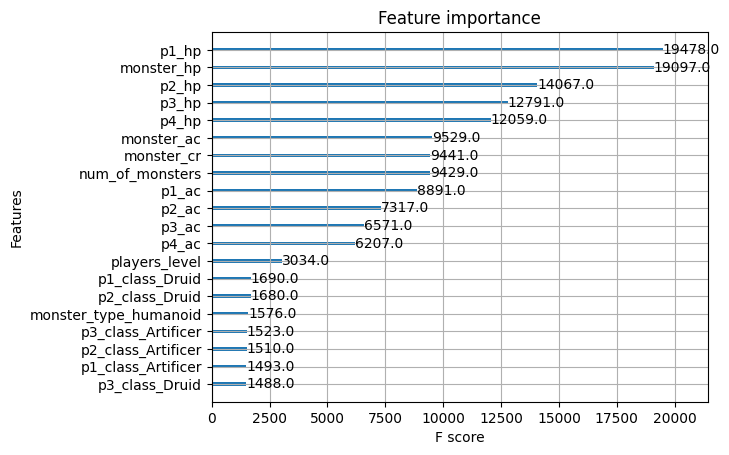

In [ ]:
plot_importance(model_OPT, max_num_features=20, importance_type='weight')

# Scaling the data with StandardScaler beforehand  

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_encoded)
X_encoded_scaled = scaler.transform(X_encoded)
df_test_encoded_scaled = scaler.transform(df_test_encoded)
X_encoded_scaled = pd.DataFrame(X_encoded_scaled, columns=X_encoded.columns)
df_test_encoded_scaled = pd.DataFrame(df_test_encoded_scaled, columns=df_test_encoded.columns)
X_encoded_scaled

,p1_hp,p1_ac,p1_avg_save,p2_hp,p2_ac,p2_avg_save,p3_hp,p3_ac,p3_avg_save,p4_hp,...,monster_type_dragon,monster_type_elemental,monster_type_fey,monster_type_fiend,monster_type_giant,monster_type_humanoid,monster_type_monstrosity,monster_type_ooze,monster_type_plant,monster_type_undead
0,1.142335,-0.994412,0.815723,1.142555,-0.549494,0.815723,2.171532,1.227785,0.815723,1.535610,...,-0.234171,4.452618,-0.204958,-0.280589,-0.165435,-0.491423,-0.393602,-0.11745,-0.190484,-0.248767
1,0.034070,-0.994412,0.815723,0.984249,1.225464,0.815723,-0.836419,-0.554420,0.815723,0.113247,...,-0.234171,-0.224587,-0.204958,-0.280589,-0.165435,-0.491423,-0.393602,-0.11745,-0.190484,-0.248767
2,-0.520063,-0.994412,-1.225907,-0.915425,0.337985,-1.225907,-0.915576,0.782233,-1.225907,-0.755975,...,-0.234171,4.452618,-0.204958,-0.280589,-0.165435,-0.491423,-0.393602,-0.11745,-0.190484,-0.248767
3,0.667365,1.669771,0.815723,0.667637,2.112943,0.815723,-0.203166,2.118887,0.815723,0.271287,...,-0.234171,-0.224587,-0.204958,-0.280589,-0.165435,-0.491423,-0.393602,-0.11745,-0.190484,-0.248767
4,0.192394,-0.994412,0.815723,0.825943,0.337985,0.815723,0.113460,-0.554420,0.815723,0.113247,...,-0.234171,-0.224587,-0.204958,-0.280589,-0.165435,2.034908,-0.393602,-0.11745,-0.190484,-0.248767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102812,0.746526,2.557833,0.815723,0.588483,-0.549494,0.815723,0.825870,-0.108869,0.815723,1.377570,...,-0.234171,-0.224587,-0.204958,-0.280589,-0.165435,-0.491423,-0.393602,-0.11745,-0.190484,-0.248767
102813,1.775630,0.337680,0.815723,0.905096,-0.105755,0.815723,0.271773,-0.554420,0.815723,0.508348,...,-0.234171,-0.224587,-0.204958,-0.280589,-0.165435,-0.491423,-0.393602,-0.11745,-0.190484,-0.248767
102814,-0.836710,-1.438443,-1.225907,-0.677966,-1.436974,-1.225907,-0.361480,1.673336,-1.225907,-1.151076,...,-0.234171,-0.224587,-0.204958,-0.280589,-0.165435,2.034908,-0.393602,-0.11745,-0.190484,-0.248767
102815,-0.995033,-0.994412,-1.225907,-0.994578,-0.549494,-1.225907,-0.678106,1.227785,-1.225907,-0.597935,...,-0.234171,-0.224587,-0.204958,-0.280589,-0.165435,-0.491423,-0.393602,-0.11745,-0.190484,-0.248767


In [ ]:
X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled = train_test_split(X_encoded_scaled, Y, test_size=.2)

# Optune with scaled data

In [ ]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, step=0.005),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'base_score': trial.suggest_float('base_score', 0.1, 0.9, step=0.1),
    }
    model = xgb.XGBRegressor(**param)
    model.fit(X_train_scaled, Y_train_scaled)
    Y_pred = model.predict(X_test_scaled)
    return mean_squared_error(Y_test_scaled, Y_pred)

In [ ]:
from sklearn.metrics import mean_squared_error

study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=200, n_jobs=-1)
study.best_params

[I 2023-12-08 10:56:55,015] A new study created in memory with name: regression
[I 2023-12-08 10:57:09,564] Trial 10 finished with value: 0.04553370742896942 and parameters: {'max_depth': 8, 'learning_rate': 0.125, 'n_estimators': 244, 'gamma': 0.9671583846709078, 'reg_lambda': 0.1962485249546719, 'scale_pos_weight': 6.994273081833879, 'base_score': 0.5}. Best is trial 10 with value: 0.04553370742896942.
[I 2023-12-08 10:57:12,798] Trial 4 finished with value: 0.04176065052032479 and parameters: {'max_depth': 7, 'learning_rate': 0.11499999999999999, 'n_estimators': 130, 'gamma': 0.18353572821098638, 'reg_lambda': 0.3994061041595711, 'scale_pos_weight': 5.908020380381623, 'base_score': 0.9}. Best is trial 4 with value: 0.04176065052032479.
[I 2023-12-08 10:57:19,563] Trial 0 finished with value: 0.08697628496202543 and parameters: {'max_depth': 1, 'learning_rate': 0.060000000000000005, 'n_estimators': 895, 'gamma': 0.4611920506809216, 'reg_lambda': 0.5868966968604817, 'scale_pos_weight'

{'max_depth': 9,
 'learning_rate': 0.135,
 'n_estimators': 527,
 'gamma': 0.010783344397713493,
 'reg_lambda': 0.18551803062456526,
 'scale_pos_weight': 2.588600213294671,
 'base_score': 0.5}

In [ ]:
# FINAL_PARAMETERS_OPT_SCALED = study.best_params
FINAL_PARAMETERS_OPT_SCALED={
  'max_depth': 10,
  'learning_rate': 0.105,
  'n_estimators': 350,
  'gamma': 0.01055558150256804,
  'reg_lambda': 0.28232001135203716,
  'scale_pos_weight': 1.6105158461610143,
  'base_score': 0.5
}

model_OPT_SCALED = xgb.XGBRegressor(**FINAL_PARAMETERS_OPT_SCALED, booster='gbtree',early_stopping_rounds=10,eval_metric='rmse')
model_OPT_SCALED.fit(
            X_train_scaled,
            Y_train_scaled,
            eval_set=[(X_train_scaled, Y_train_scaled),(X_test_scaled, Y_test_scaled)],
            verbose=100
          )

[0]	validation_0-rmse:0.37530	validation_1-rmse:0.37542
[100]	validation_0-rmse:0.12450	validation_1-rmse:0.18015
[200]	validation_0-rmse:0.09579	validation_1-rmse:0.17030
[213]	validation_0-rmse:0.09579	validation_1-rmse:0.17030


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.01055558150256804, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.105, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=350, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
model_OPT_SCALED.score(X_test_scaled, Y_test_scaled)

0.8166476759406468

In [ ]:
predict(model_OPT_SCALED, df_test_encoded_scaled, df_test_result)

Input: 


,p1_hp,p1_ac,p1_avg_save,p2_hp,p2_ac,p2_avg_save,p3_hp,p3_ac,p3_avg_save,p4_hp,...,monster_type_dragon,monster_type_elemental,monster_type_fey,monster_type_fiend,monster_type_giant,monster_type_humanoid,monster_type_monstrosity,monster_type_ooze,monster_type_plant,monster_type_undead
3417,-0.440901,-1.438443,0.815723,-0.2822,-0.549494,0.815723,0.11346,-0.999971,0.815723,0.824429,...,-0.234171,-0.224587,-0.204958,-0.280589,-0.165435,-0.491423,-0.393602,-0.11745,-0.190484,-0.248767


The combat was between 4 players level 4.0 against 5.0 monster(s) CR 1.0
Expected:  0.0
<class 'numpy.ndarray'>
Predicted:  0.19105837


<Axes: title={'center': 'Scaled'}, xlabel='F score', ylabel='Features'>

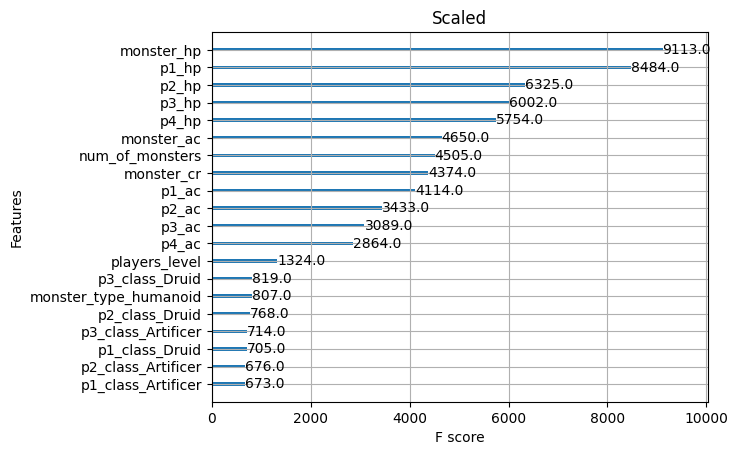

In [ ]:
plot_importance(model_OPT_SCALED, max_num_features=20, importance_type='weight', title='Scaled')

# Normalizing the data with MinMaxScaller beforehand  

In [ ]:
from sklearn.preprocessing import MinMaxScaler

normalizer = MinMaxScaler()
normalizer.fit(X_encoded)
X_encoded_normalized = normalizer.transform(X_encoded)
df_test_encoded_nomalized = normalizer.transform(df_test_encoded)
X_encoded_normalized = pd.DataFrame(X_encoded_normalized, columns=X_encoded.columns)
df_test_encoded_nomalized = pd.DataFrame(df_test_encoded_nomalized, columns=df_test_encoded.columns)
X_encoded_normalized

,p1_hp,p1_ac,p1_avg_save,p2_hp,p2_ac,p2_avg_save,p3_hp,p3_ac,p3_avg_save,p4_hp,...,monster_type_dragon,monster_type_elemental,monster_type_fey,monster_type_fiend,monster_type_giant,monster_type_humanoid,monster_type_monstrosity,monster_type_ooze,monster_type_plant,monster_type_undead
0,0.500000,0.2,1.0,0.507246,0.3,1.0,0.676056,0.7,1.0,0.579710,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.300000,0.2,1.0,0.478261,0.7,1.0,0.140845,0.3,1.0,0.318841,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.200000,0.2,0.0,0.130435,0.5,0.0,0.126761,0.6,0.0,0.159420,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.414286,0.8,1.0,0.420290,0.9,1.0,0.253521,0.9,1.0,0.347826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.328571,0.2,1.0,0.449275,0.5,1.0,0.309859,0.3,1.0,0.318841,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102812,0.428571,1.0,1.0,0.405797,0.3,1.0,0.436620,0.4,1.0,0.550725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102813,0.614286,0.5,1.0,0.463768,0.4,1.0,0.338028,0.3,1.0,0.391304,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102814,0.142857,0.1,0.0,0.173913,0.1,0.0,0.225352,0.8,0.0,0.086957,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
102815,0.114286,0.2,0.0,0.115942,0.3,0.0,0.169014,0.7,0.0,0.188406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train_normalized, X_test_normalized, Y_train_normalized, Y_test_normalized = train_test_split(X_encoded_normalized, Y, test_size=.2)

In [ ]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, step=0.005),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'base_score': trial.suggest_float('base_score', 0.1, 0.9, step=0.1),
    }
    model = xgb.XGBRegressor(**param)
    model.fit(X_train_normalized, Y_train_normalized)
    Y_pred = model.predict(X_test_normalized)
    return mean_squared_error(Y_test_normalized, Y_pred)

In [ ]:
study = optuna.create_study(direction='minimize', study_name='regression')
study.optimize(objective, n_trials=200, n_jobs=-1)
study.best_params

[I 2023-12-08 11:07:04,945] A new study created in memory with name: regression
[I 2023-12-08 11:07:30,427] Trial 5 finished with value: 0.04661237001538145 and parameters: {'max_depth': 8, 'learning_rate': 0.125, 'n_estimators': 382, 'gamma': 0.7193632281096797, 'reg_lambda': 0.38478212323469835, 'scale_pos_weight': 9.729121986177688, 'base_score': 0.9}. Best is trial 5 with value: 0.04661237001538145.
[I 2023-12-08 11:07:32,272] Trial 9 finished with value: 0.04389860106285394 and parameters: {'max_depth': 8, 'learning_rate': 0.09, 'n_estimators': 229, 'gamma': 0.5874003343333781, 'reg_lambda': 0.6557029507671394, 'scale_pos_weight': 6.0603508885949795, 'base_score': 0.9}. Best is trial 9 with value: 0.04389860106285394.
[I 2023-12-08 11:07:33,522] Trial 2 finished with value: 0.046422403367649995 and parameters: {'max_depth': 7, 'learning_rate': 0.08499999999999999, 'n_estimators': 221, 'gamma': 0.6291576393041153, 'reg_lambda': 0.9013580697128168, 'scale_pos_weight': 6.501927312466

{'max_depth': 10,
 'learning_rate': 0.055,
 'n_estimators': 375,
 'gamma': 0.010742518945249665,
 'reg_lambda': 0.7510403229976375,
 'scale_pos_weight': 1.858550284178627,
 'base_score': 0.7000000000000001}

In [ ]:
# FINAL_PARAMETERS_OPT_NORMALIZED = study.best_params
FINAL_PARAMETERS_OPT_NORMALIZED={
    'max_depth': 10,
    'learning_rate': 0.125,
    'n_estimators': 235,
    'gamma': 0.010459356211425679,
    'reg_lambda': 0.06076837113360946,
    'scale_pos_weight': 1.8140041674271903,
    'base_score': 0.8
}

model_OPT_NORMALIZED = xgb.XGBRegressor(**FINAL_PARAMETERS_OPT_NORMALIZED, booster='gbtree',early_stopping_rounds=10,eval_metric='rmse')
model_OPT_NORMALIZED.fit(
            X_train_normalized,
            Y_train_normalized,
            eval_set=[(X_train_normalized, Y_train_normalized),(X_test_normalized, Y_test_normalized)],
            verbose=100
          )

[0]	validation_0-rmse:0.47394	validation_1-rmse:0.47546
[100]	validation_0-rmse:0.11608	validation_1-rmse:0.17852
[159]	validation_0-rmse:0.09540	validation_1-rmse:0.17098


XGBRegressor(base_score=0.8, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0.010459356211425679, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.125, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=235, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
model_OPT_NORMALIZED.score(X_test_normalized, Y_test_normalized)

0.8172135514181589

In [ ]:
predict(model_OPT_NORMALIZED, df_test_encoded_nomalized, df_test_result)

Input: 


,p1_hp,p1_ac,p1_avg_save,p2_hp,p2_ac,p2_avg_save,p3_hp,p3_ac,p3_avg_save,p4_hp,...,monster_type_dragon,monster_type_elemental,monster_type_fey,monster_type_fiend,monster_type_giant,monster_type_humanoid,monster_type_monstrosity,monster_type_ooze,monster_type_plant,monster_type_undead
4312,0.085714,0.5,0.0,0.028986,0.7,0.0,0.042254,0.5,0.0,0.101449,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


The combat was between 4 players level 1.0 against 10.0 monster(s) CR 0.25
Expected:  0.0
<class 'numpy.ndarray'>
Predicted:  -0.0018837529


<Axes: title={'center': 'Normalized'}, xlabel='F score', ylabel='Features'>

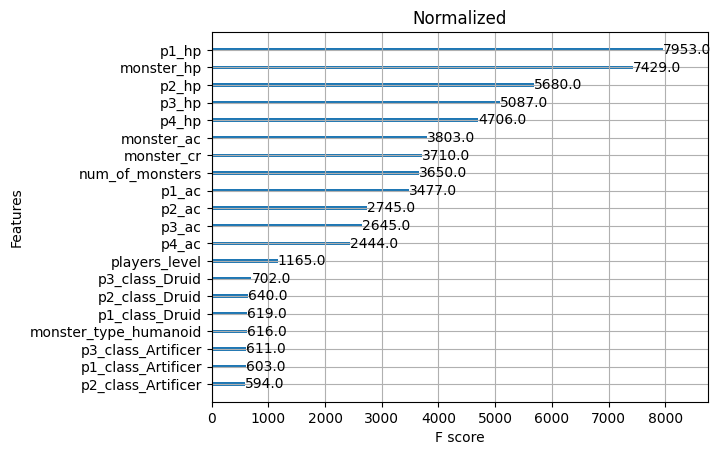

In [ ]:
plot_importance(model_OPT_NORMALIZED, max_num_features=20, importance_type='weight', title='Normalized')

In [ ]:
import pickle

# Assuming 'encoder' and 'scaler' are your OneHotEncoder and StandardScaler instances
with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

with open('normalizer.pkl', 'wb') as f:
    pickle.dump(normalizer, f)

model_OPT_NORMALIZED.save_model('model_OPT_NORMALIZED.ubj')